In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol

In [3]:
# Parameters
# simulation dependent
S0 = 500.0             # asset price
T = 5.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 100000             # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [4]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

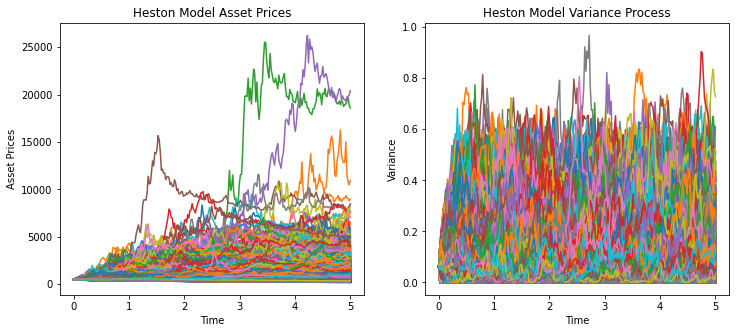

In [5]:
rho_p = 0.98
rho_n = -0.98

S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')

plt.show()

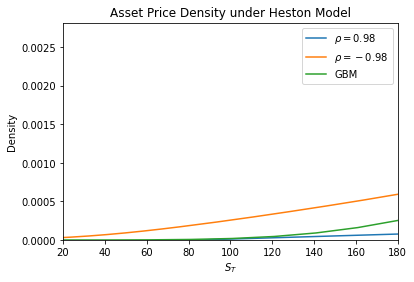

In [6]:
# simulate gbm process at time T
gbm = S0*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )

fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/py_vollib_vectorized/implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


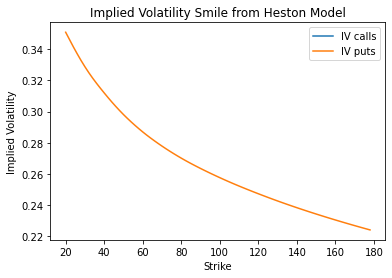

In [7]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()

# Main Idea:

The Heston Model is an options pricing model. The Heston Model utilizes stochastic volatility. The concept of stochastic volatility means that the asset price's volatility is different over time. This is different from the more fundamental options pricing models such as the Black Scholes Merton where volatilty is assumed to be constant. Thus, the Heston model is able to avoid issues such as pricing errors and all types of inefficiencies. 

# Applications:

The financial markets that are able to apply the very useful stochastic volatility Heston Model are those who can account for the evolution of stock price volatility. This includes the financial markets that are dependent on less complex options pricing models such as the Black Scholes Merton model. The Heston Model takes into account the arbitrage of volatility. 

# Purpose:

The purpose of the Heston Model is for it to follow a random process. This means the model assumes that the volatility can not be constant or even predicted. The objective function of the model is to minimize the squared difference between those calculated from the model and those which were observed.

# Function:

The Heston Model functions today as the industry standard in the options pricing industry. It's main function is to outperform and take into account the deficiencies of the Black Scholes Merton Model and other pricing models that don't account for stochastic volatility. 

# Dataset:

The dataset in this executed model is based off two different dependent parameters. The first parameters are the simulation dependent. The second parameter are the one thats are dependent on the Heston Model. The charts show that the implied volatility goes down as strike price increases. This is a great sign as it depicts the model is able to decrease volatilty even as their investments grow. Furthermore the graphs show an increase in asset prices as time passes. This is a great indication that the model and simulation were making money as intended. 

# Sources:

[Investopedia Stochastic Volatility](https://www.investopedia.com/terms/s/stochastic-volatility.asp#:~:text=Stochastic%20volatility%20is%20a%20concept%20that%20allows%20for,volatility%2C%20which%20creates%20inefficiencies%20and%20errors%20in%20pricing.?msclkid=586a16ffd0dc11ecaf0357e76efbefdf)

[Investopedia Heston Model](https://www.investopedia.com/terms/h/heston-model.asp#:~:text=The%20Heston%20Model%20is%20an%20options%20pricing%20model,to%20the%20Black-Scholes%20model%20that%20holds%20volatility%20constant.?msclkid=12dd4043d0dc11ec82afdd44f9f103b0)

[Science Direct](https://www.sciencedirect.com/science/article/pii/S0377042714005767?msclkid=0b4262e9d0dd11ec9d240949a22fbdb6)

[Wikipedia](https://en.wikipedia.org/wiki/Heston_model?msclkid=7bd65be6d0de11ec99074df2dcc12fea)

[asx portfolio (code for model)](https://asxportfolio.com/options-volatility-heston-model-simulation)